<a href="https://colab.research.google.com/github/NGUYENGREENY/OpenCV-python/blob/main/13_tf_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning based Object Detection
**Satya Mallick, LearnOpenCV.com**

1. **Architecture** : Mobilenet based Single Shot Multi-Box (SSD)
2. **Framework** : Tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Download Model files from Tensorflow model ZOO

Model files can be downloaded from the Tensorflow Object Detection Model Zoo
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

**The cell given below downloads a mobilenet model**

## Download mobilenet model file
The code below will run on Linux / MacOS systems.
Please download the file http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz

Uncompress it and put it in models folder.

**ssd_mobilenet_v2_coco_2018_03_29** <br>
|─ checkpoint <br>
|─ **frozen_inference_graph.pb** <br>
|─ model.ckpt.data-00000-of-00001 <br>
|─ model.ckpt.index <br>
|─ model.ckpt.meta <br>
|─ pipeline.config <br>
|─ saved_model <br>
|─── saved_model.pb <br>
|─── variables <br>

In [1]:
import os
import cv2
import numpy as np
import urllib
import matplotlib.pyplot as plt
%matplotlib inline

# Create config file from frozen graph

1. Extract the files 
2. Run the [tf_text_graph_ssd.py](https://github.com/opencv/opencv/blob/master/samples/dnn/tf_text_graph_ssd.py) file with input as the path to the frozen_graph.pb file and output as desired.



**A sample config file has been included in the models folder**

In [3]:
modelFile = "/content/drive/MyDrive/Open CV/13_Object_Detection/models/ssd_mobilenet_v2_coco_2018_03_29/frozen_inference_graph.pb"
configFile = "/content/drive/MyDrive/Open CV/13_Object_Detection/models/ssd_mobilenet_v2_coco_2018_03_29.pbtxt"
classFile = "/content/drive/MyDrive/Open CV/13_Object_Detection/coco_class_labels.txt"

if not os.path.isdir('/content/drive/MyDrive/Open CV/13_Object_Detection/models'):
    os.mkdir("/content/drive/MyDrive/Open CV/13_Object_Detection/models")

if not os.path.isfile(modelFile):
    os.chdir("/content/drive/MyDrive/Open CV/13_Object_Detection/models")
    # Download the tensorflow Model
    urllib.request.urlretrieve('http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v2_coco_2018_03_29.tar.gz', 'ssd_mobilenet_v2_coco_2018_03_29.tar.gz')

    # Uncompress the file
    !tar -xvf ssd_mobilenet_v2_coco_2018_03_29.tar.gz

    # Delete the tar.gz file
    os.remove('ssd_mobilenet_v2_coco_2018_03_29.tar.gz')

    # Come back to the previous directory
    os.chdir("..")

# Check Class Labels 


In [4]:
with open(classFile) as fp:
    labels = fp.read().split("\n")
print(labels)

['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush', '']


**The steps for performing infernece using a DNN model are summarized below:**
    
1. Load the model and input image into memory.
2. Detect objects using a forward pass through the network.
3. Display the detected objects with bounding boxes and class labels.

# Read Tensorflow Model

In [5]:
# Read the Tensorflow network
net = cv2.dnn.readNetFromTensorflow(modelFile, configFile)

# Detect Objects


In [6]:
# For ach file in the directory
def detect_objects(net, im):
    dim = 300
    
    # Create a blob from the image
    blob = cv2.dnn.blobFromImage(im, 1.0, size=(dim, dim), mean=(0,0,0), swapRB=True, crop=False)

    # Pass blob to the network
    net.setInput(blob)
    
    # Peform Prediction
    objects = net.forward()
    return objects


In [7]:
def display_text(im, text, x, y):
    
    # Get text size 
    textSize = cv2.getTextSize(text, FONTFACE, FONT_SCALE, THICKNESS)
    dim = textSize[0]
    baseline = textSize[1]
            
    # Use text size to create a black rectangle    
    cv2.rectangle(im, (x,y-dim[1] - baseline), (x + dim[0], y + baseline), (0,0,0), cv2.FILLED);
    # Display text inside the rectangle
    cv2.putText(im, text, (x, y-5 ), FONTFACE, FONT_SCALE, (0, 255, 255), THICKNESS, cv2.LINE_AA)


# Display Objects

In [8]:
FONTFACE = cv2.FONT_HERSHEY_SIMPLEX
FONT_SCALE = 0.7
THICKNESS = 1

def display_objects(im, objects, threshold = 0.25):

    rows = im.shape[0]; cols = im.shape[1]

    # For every Detected Object
    for i in range(objects.shape[2]):
        # Find the class and confidence 
        classId = int(objects[0, 0, i, 1])
        score = float(objects[0, 0, i, 2])
        
        # Recover original cordinates from normalized coordinates
        x = int(objects[0, 0, i, 3] * cols)
        y = int(objects[0, 0, i, 4] * rows)
        w = int(objects[0, 0, i, 5] * cols - x)
        h = int(objects[0, 0, i, 6] * rows - y)
        
        # Check if the detection is of good quality
        if score > threshold:
            display_text(im, "{}".format(labels[classId]), x, y)
            cv2.rectangle(im, (x, y), (x + w, y + h), (255, 255, 255), 2)
    
    # Convert Image to RGB since we are using Matplotlib for displaying image
    mp_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(30,10)); plt.imshow(mp_img); plt.show();

# Results

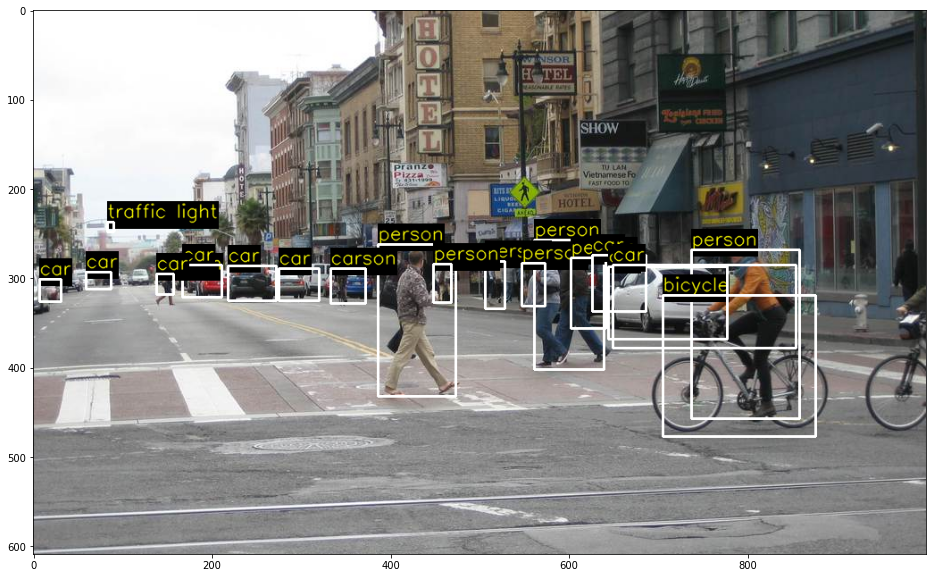

In [10]:
im = cv2.imread('/content/drive/MyDrive/Open CV/13_Object_Detection/images/street.jpg')
objects = detect_objects(net, im)
display_objects(im, objects)

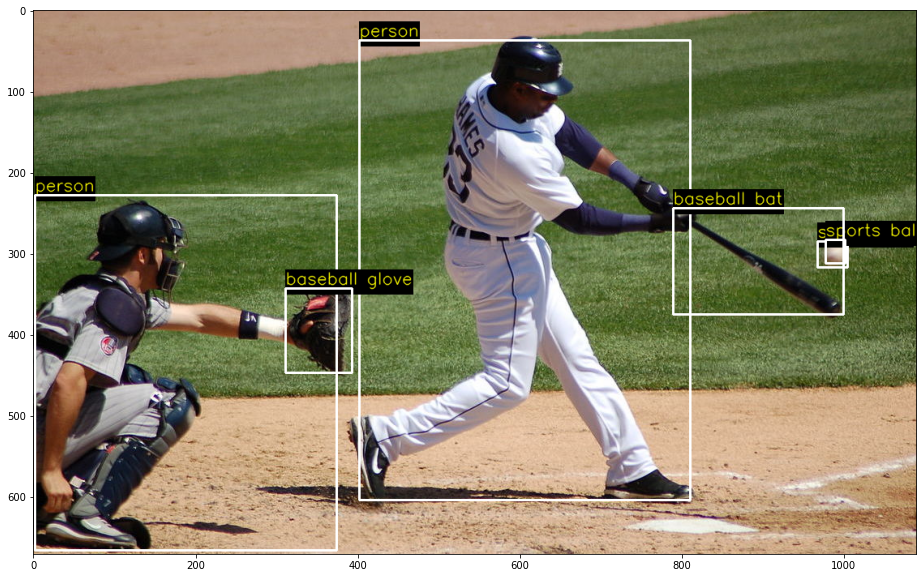

In [11]:
im = cv2.imread('/content/drive/MyDrive/Open CV/13_Object_Detection/images/baseball.jpg')
objects = detect_objects(net, im)
display_objects(im, objects, 0.2)

# False Alarm

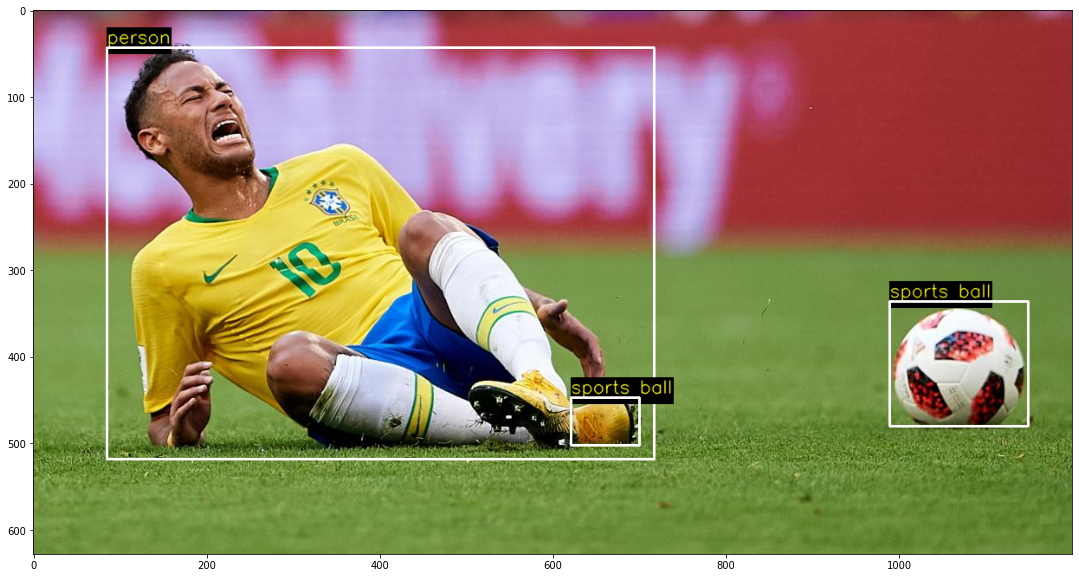

In [12]:
im = cv2.imread('/content/drive/MyDrive/Open CV/13_Object_Detection/images/soccer.jpg')
objects = detect_objects(net, im)
display_objects(im, objects)

# Thank You!